## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2. Beyond Fast Track
Goal of Phase 2 is to get a final model addressing all issues and inaccuracies encountered during Phase 1(Fast Track)

## Fast Track Conclusions
R squared = 66%. The linear model explains 66% of the variations in the house price. 
The model tends to under predict (predicted value < actual value), especially on the high end of the price range 
Training and test performances seem close based on visualization, but Mean Square Error (MSE) for test is 22% higher than for the training set. 
Presence of outliers is evidenced by the prediction errors visualization. They are likely to be responsible for a good part of the inaccuracy of the model. Needs to be addressed in forthcoming work.

## Workflow:
1. address non-numerical data
2. Address the issue due to the presence of outliers  
3. Address potential collinearity between features  
4. Features selection step 1 
5. Address the issue of missing values  
6. Address categorical data  
7. Features selection step 2  
8. Features transformation and scaling  
9. test/train split or K fold cross validation
10. QC and Check assumptions: Linearity/ Model Residuals are normally distrib/ Homoscedasticity


## Importing needed modules, libraries ...

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Data import

In [33]:
df = pd.read_csv('kc_house_data.csv')

In [34]:
# how many data points(rows)? How many variables (columns)?
df.shape

(21597, 21)

# Looking for duplicated entries

In [35]:
#Flag duplicates with True (if any)
df.duplicated().value_counts()

False    21597
dtype: int64

In [36]:
#No duplicates in the data

## Reminder  
Target variable (i.e. independent variable) = 'price'  
21597 raw data points
20 potential descriptors

# 1. Looking for non-numerical data 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [38]:
# columns 'date' and 'sqft_basement' are non numerical
# what is the data type of sqft_basement?
type(df['sqft_basement'][0])

str

In [39]:
# checking unique values of column sqft_basement
np.sort(df['sqft_basement'].unique())

array(['0.0', '10.0', '100.0', '1000.0', '1008.0', '1010.0', '1020.0',
       '1024.0', '1030.0', '1040.0', '1050.0', '1060.0', '1070.0',
       '1080.0', '1090.0', '110.0', '1100.0', '1110.0', '1120.0',
       '1130.0', '1135.0', '1140.0', '1150.0', '1160.0', '1170.0',
       '1180.0', '1190.0', '120.0', '1200.0', '1210.0', '1220.0',
       '1230.0', '1240.0', '1245.0', '1248.0', '1250.0', '1260.0',
       '1270.0', '1275.0', '1280.0', '1281.0', '1284.0', '1290.0',
       '130.0', '1300.0', '1310.0', '1320.0', '1330.0', '1340.0',
       '1350.0', '1360.0', '1370.0', '1380.0', '1390.0', '140.0',
       '1400.0', '1410.0', '1420.0', '143.0', '1430.0', '1440.0', '145.0',
       '1450.0', '1460.0', '1470.0', '1480.0', '1481.0', '1490.0',
       '150.0', '1500.0', '1510.0', '1520.0', '1525.0', '1530.0',
       '1540.0', '1548.0', '1550.0', '1560.0', '1570.0', '1580.0',
       '1590.0', '160.0', '1600.0', '1610.0', '1620.0', '1630.0',
       '1640.0', '1650.0', '1660.0', '1670.0', '1680.0',

In [40]:
# check number of records with ? as sqft_basement
df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1770.0        1
516.0         1
2580.0        1
506.0         1
415.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [41]:
# column sqft_basement has a question mark !!
# How many '?' in sqft_basement column? in %
print( "% of '?' in column sqft_basement : ",100* len(df[df['sqft_basement']=='?'])/len(df) ) 
print( "# of '?' in column sqft_basement : ", len(df[df['sqft_basement']=='?']) )

% of '?' in column sqft_basement :  2.1021438162707784
# of '?' in column sqft_basement :  454


### Rationale:
2% of the records don't have basement square footage info.
Should we even worry about sqft_basement?
I think it is an important predictor of the price of the house, so I would like to keep it and use it as a predictor.
As I believe it is an important predictor, I don't want to replace the "?" by a made-up value.
So my plan is to check the correlation between sqft_basement and price to confirm it is an important factor in the price and then (if confirmed) remove the 2% of records for which we don't know whether there is a basement or no.


In [42]:
# check the correlation between sqft_basement and price
# select only these 2 variables and sqft_living and id
# Why sqft_living ( footage of the home)? Because Intuitively, it should be one of the main predictor of the house price.
# Why id ( unique identifier)? Because Intuitively, it should NOT be correlated to the house price.
# these correlation will serve us as reference
df_basement_price = df[['id', 'sqft_basement','price','sqft_living']]

# remove all records with ? in sqft_basement
df_basement_price=df_basement_price.loc[ df_basement_price['sqft_basement'] != '?' ]

# change type of sqft_basement to allow correlation process
df_basement_price['sqft_basement']=df_basement_price['sqft_basement'].astype('float64')
df_basement_price.dtypes

id                 int64
sqft_basement    float64
price            float64
sqft_living        int64
dtype: object

In [43]:
df_basement_price.corr()

,id,sqft_basement,price,sqft_living
id,1.000000,-0.004548,-0.015796,-0.011721
sqft_basement,-0.004548,1.000000,0.325008,0.434576
price,-0.015796,0.325008,1.000000,0.702328
sqft_living,-0.011721,0.434576,0.702328,1.000000


## Intermediary Conclusion
#### The correlation between price and sqft_living is 70%.
#### The correlation between price and sqft_basement  is 32.5%
#### The correlation between price and id is 1.6%
#### This confirms that sqft_basement is a significant predictor of the price, but not a prevalent one.
#### Therefore, I would rather remove the 2% of data with a "?" rather than make up information for that predictor.


In [44]:
# removing sqft_basement = ? from data
# remove all records with ? in sqft_basement
df=df.loc[ df['sqft_basement'] != '?' ]

# change type of sqft_basement to float64
df['sqft_basement']=df['sqft_basement'].astype('float64')
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [45]:
# check date column. type?
print(df.date[0])
type(df.date[0])


10/13/2014


str

In [46]:
# change date type to datetime
# then, keep only the year from 'date' (date it was sold) and make it an integer
df['date']=pd.to_datetime(df['date']).dt.year.astype('int')


In [47]:
# checking  date type
df['date'][0:5]

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int32

## Looking for NaN values


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
id               21143 non-null int64
date             21143 non-null int32
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       18804 non-null float64
view             21082 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     17389 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(9), int32(1), int64(11)
memory usage: 4.1 MB


### NaN values issues with waterfront, view, yr_renovated

In [49]:
# Let's check waterfront
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [nan  0.  1.]
% of NaN in waterfront :  11.062763089438585
% of 0 in waterfront :  88.26561982689306
% of 1 in waterfront :  0.6716170836683536


In [50]:
# 11 % of the values in waterfront are Nan
# as the majority of houses are not waterfrnt( 88% of zeroes), we will replace NaN with zero
df['waterfront'] = df['waterfront'].fillna(0)

In [51]:
# Let's check waterfront again
print( 'values in waterfront : ', df['waterfront'].unique() )
print(  '% of NaN in waterfront : ', 100*(len(df) - np.sum(df['waterfront'].value_counts()))  / len(df) )
print( '% of 0 in waterfront : ', 100*(np.sum(df['waterfront'].value_counts()[0]))  / len(df) )
print( '% of 1 in waterfront : ',100*(np.sum(df['waterfront'].value_counts()[1]))  / len(df) )

values in waterfront :  [0. 1.]
% of NaN in waterfront :  0.0
% of 0 in waterfront :  99.32838291633165
% of 1 in waterfront :  0.6716170836683536


In [52]:
# Let's check view
print( 'values in view : ', df['view'].unique() )


values in view :  [ 0. nan  3.  4.  2.  1.]


In [53]:
# 'view' is supposed to mean whether the data has been viewed. 
# This does not make sense to me  as the data stops in 2015 
# So we drop this feature 'view'

In [54]:
# check most recent year for house sold:
df['date'].max()

2015

In [55]:
# drop column 'view'
df.drop('view',axis =1, inplace = True)

In [56]:
# check # of columns was reduced to 20
df.shape

(21143, 20)

In [57]:
# check yr_renovated
# print all distinct values
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )
print(  'occurences for each distinct value in yr_renovated : ', df['yr_renovated'].value_counts() )
print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991.   nan 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984.
 1954. 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999.
 1998. 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 1980. 1971. 1979.
 1997. 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963. 1951.
 1962. 2001. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1975. 1964.
 1973. 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
occurences for each distinct value in yr_renovated :  0.0       16666
2014.0       69
2003.0       31
2013.0       31
2007.0       30
          ...  
1953.0        1
1944.0        1
1934.0        1
1971.0        1
1959.0        1
Name: yr_renovated, Length: 69, dtype: int64
% of 0 in yr_renovated:  78.82514307335761
% of NaN in yr_renovated:  17.755285437260557


In [58]:
# As there is a majority of yr_renovated = 0 (79%) and 18% of the values are NaN, 
# we will replace NaN by the mode: 0
df['yr_renovated'].fillna(value =0,inplace = True)

In [59]:
# check 
print( 'values in yr_renovated : ', df['yr_renovated'].unique() )

print(  '% of 0 in yr_renovated: ' , 100* np.sum(df['yr_renovated'].value_counts()[0]) / len(df) )
print(  '% of NaN in yr_renovated: ' , 100* (len(df)  - np.sum(df['yr_renovated'].value_counts()) ) / len(df) )

values in yr_renovated :  [   0. 1991. 2002. 2010. 1992. 2013. 1994. 1978. 2005. 2003. 1984. 1954.
 2014. 2011. 1983. 1945. 1990. 1988. 1977. 1981. 1995. 2000. 1999. 1998.
 1970. 1989. 2004. 1986. 2007. 1987. 2006. 1985. 1980. 1971. 1979. 1997.
 1950. 1969. 1948. 2009. 2015. 1974. 2008. 1968. 2012. 1963. 1951. 1962.
 2001. 1953. 1993. 1996. 1955. 1982. 1956. 1940. 1976. 1975. 1964. 1973.
 1957. 1959. 1960. 1967. 1965. 1934. 1972. 1944. 1958.]
% of 0 in yr_renovated:  96.58042851061818
% of NaN in yr_renovated:  0.0


In [60]:
# for yr_renovated, 0 doesn't make sense.
# We will replace 0 by the year the house was built. 
# This will enable yr_renovated to be used as a predictor
df['yr_renovated'] = df[['yr_renovated','yr_built']].max(axis=1)

In [61]:
# check
df['yr_renovated'].value_counts()

2014.0    611
2005.0    464
2006.0    463
2003.0    446
2004.0    443
         ... 
1901.0     27
1902.0     26
1933.0     24
1935.0     19
1934.0     15
Name: yr_renovated, Length: 116, dtype: int64

### We created inadvertently a heavy correlation between yr_correlated and yr_built. 
### We will only keep the predictor that has the highest correlation to price.
### Check correlation:

In [62]:
# check we don't have any NaN values left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 20 columns):
id               21143 non-null int64
date             21143 non-null int32
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       21143 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     21143 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(8), int32(1), int64(11)
memory usage: 3.9 MB


# 2. Detect and Address Outliers

In [100]:
max(1,3)

3

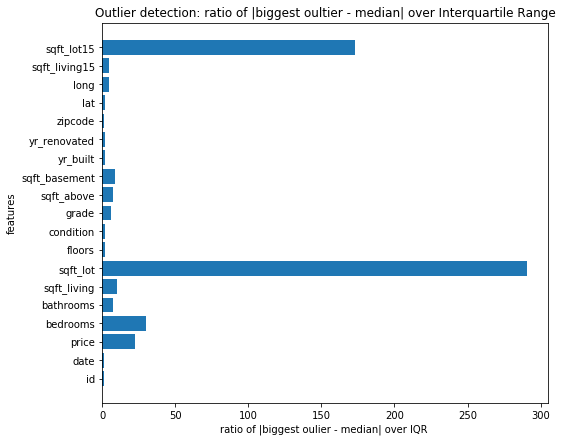

In [105]:
# detect ouliers using InterQuartile Range (IQR) 
dico={}
for col in df.columns:
    if df[col].quantile(.75) - df[col].quantile(.25)  != 0:
#         For features with IQR > 0, calculate the distance of the biggest outlier to the median 
        maxi=max(df[col].max() - df[col].median() ,  df[col].median() -df[col].min() )
#     divide by IQR 
        dico[col] = maxi  /  (df[col].quantile(.75) - df[col].quantile(.25))
# visualization of the ratio with a bar plot
plt.figure(figsize = (8,7))
plt.barh( list(dico.keys()) ,list(dico.values())  )
plt.xlabel('ratio of |biggest oulier - median| over IQR ')
plt.ylabel('features')
plt.title('Outlier detection: ratio of |biggest oultier - median| over Interquartile Range')
plt.show();

#### sqft_lot and sqft_lot15 have the "biggest" outliers. Let's check them first:

In [125]:
df['sqft_lot'].quantile(.75) - df['sqft_lot'].quantile(.25), df['sqft_lot15'].quantile(.75) - df['sqft_lot15'].quantile(.25)

(5652.5, 4987.0)

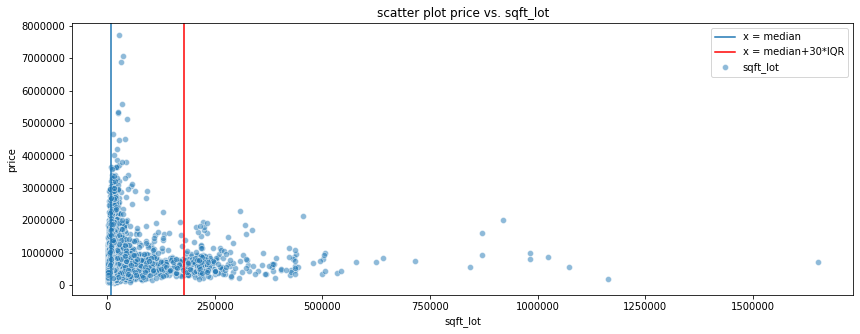

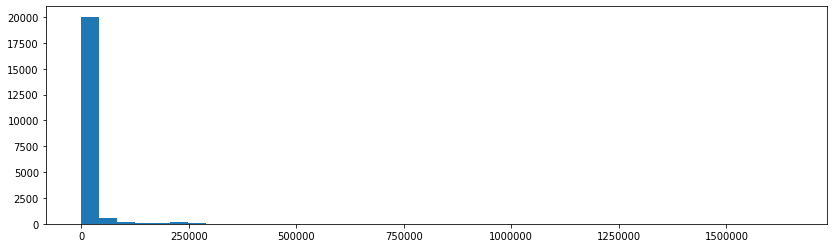

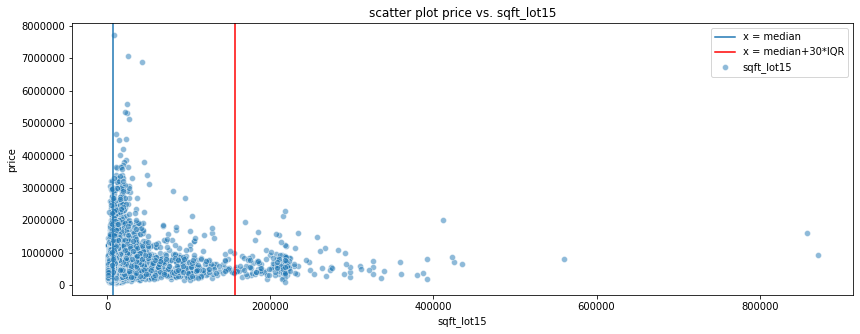

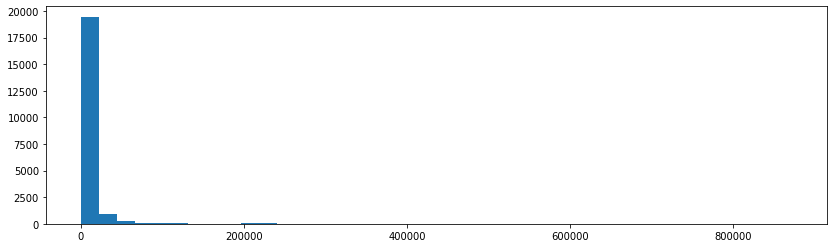

In [140]:
# Visualization of sqft_lot and sqft_lot15 vs the target variable price
df_plot = df[['price','sqft_lot','sqft_lot15']]

for feat in ['sqft_lot','sqft_lot15']:
    plt.figure(figsize=(14,5))
    sns.scatterplot(x=feat, y='price',data=df_plot,alpha=0.5,label = feat)
    plt.axvline(x=df_plot[feat].median(), label = 'x = median')
    IQR = df[feat].quantile(.75) - df[feat].quantile(.25)
    plt.axvline(x=df_plot[feat].median() + 30*IQR, label = 'x = median+30*IQR',color = 'r')
    plt.title('scatter plot price vs. {}'.format(feat))
    plt.legend()
    plt.show();  
    plt.figure(figsize=(14,4))
    plt.hist(df[feat],bins=40)
    plt.title('histogram of {}'.format(feat))
    plt.show();

In [141]:
df_plot.corr()

,price,sqft_lot,sqft_lot15
price,1.000000,0.087937,0.083192
sqft_lot,0.087937,1.000000,0.720649
sqft_lot15,0.083192,0.720649,1.000000


## Conclusion for features sqft_lot and sqft_lot15
#### Very strong correlation between sqft_lot and sqft_lot15. ~72%
#### Very small correlation between sqft_lot(15) and target variable price
#### No linear relationship between sqft_lot(15) and target variable price
#### There are indeed outliers but it is of secondary timportance compared to the observations above.
#### We will not use sqft_lot or sqft_lot15 for predicting price.

## Looking for categorical data

In [ ]:
# scatterplot of price vs. each variable

%matplotlib inline

# list of 15 predictors (x)
listx = list(df.columns.drop('price').drop('date'))
print('number of predictors: ', len(listx))
print('predictors: ',listx)

for elem in listx:
    df.plot(kind = 'scatter', x = elem, y = 'price',
            alpha=0.4, color= 'b')
    plt.show();
    


## Intermediary conclusion:  
id and zipcode seem to be the only truly categorical variables.  
But we also have discrete variables (condition, numbers of rooms...)  
id is an identifier, we can drop it.  
We'll drop zipcode for now.  

In [ ]:
# let's also drop date for now 
df= df.drop(['id','date','zipcode'],axis = 1)

In [ ]:
# check
df

## Train - Test Split

In [ ]:
X= df.drop(['price'],axis=1)
y=df['price']

linreg = LinearRegression()
# Split the data randomly into training and test sets. 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

# check sizes
print( [ t.shape[:] for t in [X_train,X_test,y_train,y_test]])
print( X_test.shape[0]/( X_train.shape[0]+X_test.shape[0] ) )

## Multiple linear regression

In [ ]:

X_train_int = sm.add_constant(X_train)  # contains all predictors and a constant column =1 for intercept
model = sm.OLS(y_train,X_train_int).fit() # y_train is a one column dataframe containing the dependent variable
model.summary()

## Fast track QC 


In [ ]:
# prediction for test  and training set:
X_test_int = sm.add_constant(X_test) # adds a constant column =1 for intercept (similar to X_train_int)
y_hat_test = model.predict(X_test_int)
y_hat_train = model.predict(X_train_int)

In [ ]:
# visualization of residuals

# conversion of results for training set into a dataframe
y_train_df = pd.DataFrame(y_train)
y_hat_train_df = pd.DataFrame(y_hat_train)
y_train_df=pd.concat([y_train_df,y_hat_train_df],axis=1)
y_train_df.columns = ['actual_price','predicted_price']
y_train_df['flag']='training set'

# conversion of results for test set into a dataframe
y_test_df = pd.DataFrame(y_test)
y_hat_test_df = pd.DataFrame(y_hat_test)
y_test_df=pd.concat([y_test_df,y_hat_test_df],axis=1)
y_test_df.columns = ['actual_price','predicted_price']
y_test_df['flag']='testing set'

# putting together the training and test sets
y_plot = pd.concat ([y_train_df,y_test_df],axis = 0)

# scatter plot of training and test sets' predictions vs. actuals + line y=x for reference
plt.figure(figsize=(16,10))
sns.scatterplot(x='actual_price', y='predicted_price',hue ='flag',data=y_plot )
plt.plot([0,4000000],[0,4000000])
plt.show();

In [ ]:
res_test=y_hat_test-y_test
res_train=y_hat_train-y_train

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot( res_test )
sns.distplot( res_train )
plt.show();

In [ ]:

# Calculate mean square errors
train_mse = mean_squared_error(y_train,y_hat_train)
test_mse = mean_squared_error(y_test,y_hat_test) 
print ('train_mse :',train_mse)
print ('test_mse :',test_mse)
print ('difference (in %):  ', 100*(abs(train_mse-test_mse)) / train_mse)

## Fast Track Conclusions
R squared = 66%. The linear model explains 66% of the variations in the house price.
The model tends to under predict (predicted value < actual value), especially on the high end of the price range
Training and test performances seem close based on visualization, but Mean Square Error (MSE) for test is 22% higher than for the training set. 
Presence of outliers is evidenced by the prediction errors visualization. They are likely to be responsible for a good part of the inaccuracy of the model. Needs to be addressed in forthcoming work.
  
## Notes for work beyond Fast Track
Address the issue due to the presence of outliers  
Address the issue of missing values  
Address categorical data  
Address potential collinearity between features  
Features selection  
Features transformation and scaling   
K fold cross validation?
